# <img src='https://analyticsbw.org/wp-content/uploads/2020/07/abw-logo.png' align='after' width=120> <br />Assignment 2 | ABW<br /><p>Leon van Rooijen & Miji Trenkel</p>
---

In [ ]:
import sys
at_colab = "google.colab" in sys.modules
if 'google.colab' in sys.modules:
    import os
    from google.colab import files
    # just check if we already uploaded, may we restart the runtime and run all cells
    if not os.path.isfile('Data Ermera Timor Leste.xlsx'):
        uploaded = files.upload()

In [ ]:

import pandas as pd

data = pd.read_excel( 'Data Ermera Timor Leste.xlsx', sheet_name=None )

In [ ]:
distances = data['Distances']
homes     = data['Homes']
locations = data['Potential locations']

# Visualize the data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
def ShowFacilityLocation( xC, yC, xF, yF, X=[], Y=[], served=None ):
    plt.plot( xC,yC, 'o' )
    plt.plot( xF,yF, 's', mfc='none' )
    [ plt.plot( [xC[i],xF[j]], [yC[i],yF[j]], 'g-' ) for j in range(len(X)) if X[j] for i in range(len(Y)) if Y[i][j] ] 
    for j in range(len(X)):
      if X[j] > .5:
        plt.plot( xF[j],yF[j], 's', color='y' )
    if not served is None:
        plt.title( '{:.2f}%'.format(served/len(xC)*100) )
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (13,8)

# Prerequisites for mathematical optimization


In [ ]:
import shutil
if not shutil.which('pyomo'):
    !pip install -q pyomo
    assert(shutil.which('pyomo'))

import sys
if 'google.colab' in sys.modules:
    !apt-get install -y -qq coinor-cbc

!wget -N -q "https://ampl.com/dl/open/bonmin/bonmin-linux64.zip"
!unzip -o -q bonmin-linux64


import pyomo.environ as pyo

if at_colab:
    # we add glpk now
    !sudo apt install libglpk-dev python3.8-dev libgmp3-dev
    !apt-get install -y -qq glpk-utils

    #and also cbc
    !apt-get install -y -qq coinor-cbc

if at_colab:
    cbc  = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
    glpk = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
else:
    cbc  = pyo.SolverFactory('cbc') # adapt if needed    
    glpk = pyo.SolverFactory('glpk') # adapt if needed

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgmp3-dev is already the newest version (2:6.1.2+dfsg-2).
libglpk-dev is already the newest version (4.65-1).
python3.8-dev is already the newest version (3.8.12-1+bionic1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# Linear optimization model

CPU times: user 10.7 s, sys: 250 ms, total: 11 s
Wall time: 13.2 s
----- [ Summary ] -----
Households with access:  985.0
Optimal locations:
Location :  16
Location :  34
Location :  37
Location :  45
Location :  88
----- [ Map ] -----


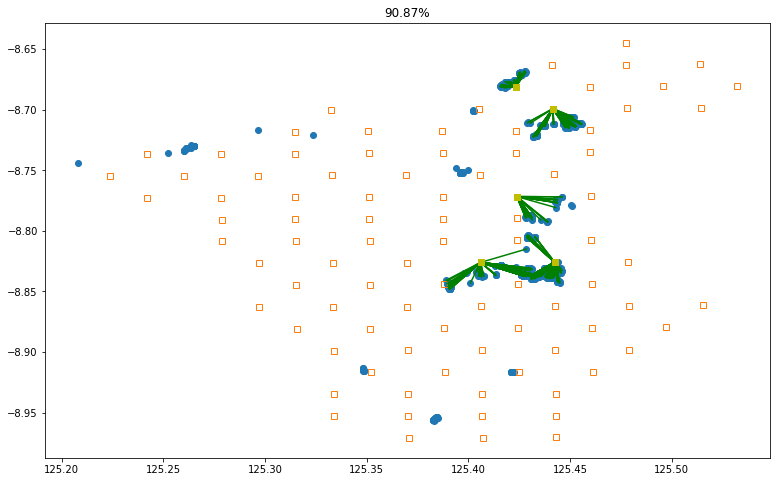

In [ ]:

def hospital_model(maxDistance = 3, householdSize = 1, numberOfHospitals = 5): 
  model = pyo.ConcreteModel("Hospital locations")

  #Home and location sets
  model.homes = len(homes)
  model.locations = len(locations)

  model.I = range(model.homes)
  model.J = range(model.locations)

  #Variables that need to be evaluated
  model.y = pyo.Var(model.I, model.J, domain=pyo.Binary)
  model.x = pyo.Var(model.J, domain=pyo.Binary)

  #Objective
  model.placedLocations = pyo.Objective(expr = pyo.quicksum(model.y[home, hospital]*householdSize for home in model.I for hospital in model.J), sense=pyo.maximize)

  #There is only budget to build a certain amount of hospitals
  model.costConstraint = pyo.Constraint(expr = (sum(model.x[hospital] for hospital in model.J)) <= numberOfHospitals)

  #People can only be served by hospitals that are opened.
  def assign_if_open_rule(model, i, j ):
    return model.y[i,j] <= model.x[j]
  model.assign = pyo.Constraint( model.I, model.J, rule=assign_if_open_rule )

  #People can be served by only one hospital maximum
  def assigned_one_hospital_rule(model, i):
    return pyo.quicksum([model.y[i,j] for j in model.J]) <= 1
  model.assigned = pyo.Constraint(model.I, rule=assigned_one_hospital_rule)

  #The distance should be less than the maximum allowed travel distance
  def distance_constraint_rule(model, i, j):
    if(distances.loc[i, j] > maxDistance):
      return model.y[i, j] == 0
    return pyo.Constraint.Skip
  model.open = pyo.Constraint(model.I, model.J, rule=distance_constraint_rule)

  return model

#Obtain the solution
solution = hospital_model()
%time results = cbc.solve(solution)

print("----- [ Summary ] -----")
print("Households with access: ", pyo.value(solution.placedLocations))
print("Optimal locations:")
for location in solution.J:
  if(solution.x[location]() == 1):
    print("Location : ", location)

print("----- [ Map ] -----")
X = [ pyo.value( solution.x[j] ) >= .5 for j in solution.J ]
Y = [ [ pyo.value( solution.y[i,j] ) >= .5 for j in solution.J ] for i in solution.I ]
ShowFacilityLocation( xC, yC, xF, yF, X, Y, pyo.value(solution.placedLocations))


